In [63]:
from IPython.display import Image
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
from matplotlib.mlab import bivariate_normal

import numpy as np

import tensorflow as tf

%matplotlib inline

In [64]:
dim = 2
plot_x_lim = 8.
plot_y_lim = 8.
x = np.arange(-plot_x_lim, plot_x_lim, 0.1)
y = np.arange(-plot_y_lim, plot_y_lim, 0.1)
X, Y = np.meshgrid(x, y)

### The Bootstrap and Robust Divergences

##### A Mispecified Model with Outliers

Let's draw data from a Student-T but with some outliers drawn from a shifted Cauchy.

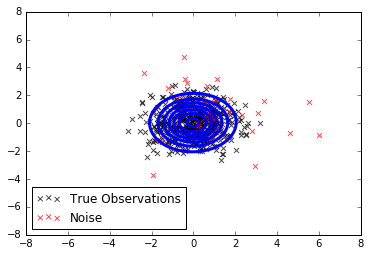

In [65]:
### Make Dataset
N_true = 500
N_outlier = 50
N = N_true + N_outlier

true_obs = np.random.standard_t(df=100, size=(N_true, dim))
noise_obs = np.random.standard_cauchy(size=(N_outlier, dim)) + 1.
data = np.vstack([true_obs, noise_obs])
np.random.shuffle(data)

### Fit Gaussian Model to True Data
mu = np.mean(true_obs, axis=0)
sigma = np.cov(true_obs.T)

### Plot
plt.scatter(true_obs[:,0], true_obs[:,1], marker='x', s=25, c='k', alpha=.7, label="True Observations")
plt.scatter(noise_obs[:,0], noise_obs[:,1], marker='x', s=25, c='r', alpha=.7, label="Noise")

Z = bivariate_normal(X, Y, sigmax=np.sqrt(sigma[0,0]), sigmay=np.sqrt(sigma[1,1]), mux=mu[0], muy=mu[1], sigmaxy=sigma[0,1])
plt.contour(X,Y,Z, colors='blue', linewidths=3)

plt.xlim([-plot_x_lim, plot_x_lim])
plt.ylim([-plot_y_lim, plot_y_lim])
plt.legend(loc=3)
plt.show()

##### Maximum Likelihood Estimate

Let's see what a Normal model fit to the data looks like

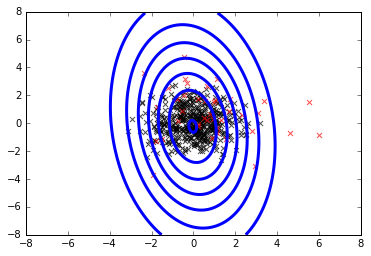

In [66]:
mu = np.mean(data, axis=0)
sigma = np.cov(data.T)

plt.scatter(true_obs[:,0], true_obs[:,1], marker='x', s=25, c='k', alpha=.7)
plt.scatter(noise_obs[:,0], noise_obs[:,1], marker='x', s=25, c='r', alpha=.7)

Z = bivariate_normal(X, Y, sigmax=np.sqrt(sigma[0,0]), sigmay=np.sqrt(sigma[1,1]), mux=mu[0], muy=mu[1], sigmaxy=sigma[0,1])
plt.contour(X,Y,Z, colors='blue', linewidths=3)

plt.xlim([-plot_x_lim, plot_x_lim])
plt.ylim([-plot_y_lim, plot_y_lim])
plt.show()

##### Bootstrap Estimate

Let's try bootstrapping...

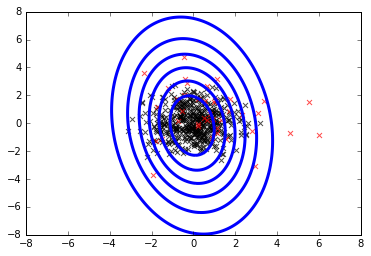

In [67]:
def uniform_bootstrap_resample(X, n=None, labels=None):
    """ Bootstrap resample an array_like
        Parameters
        ----------
        X : array_like
        data to resample
        n : int, optional
        length of resampled array, equal to len(X) if n==None
        Results
        -------
        returns X_resamples
        """
    if n == None:
        n = len(X)
    resample_i = np.floor(np.random.rand(n)*len(X)).astype(int)
    X_resample = X[resample_i]
    if labels != None:
        Y_resample = labels[resample_i]
        return X_resample, Y_resample
    return X_resample


### Get Bootstrap Estimates
K = 3
mu_avg = np.zeros((dim,))
sigma_avg = np.zeros((dim,dim))

for k in xrange(K):
    X_k = uniform_bootstrap_resample(data, N)
    mu_avg += np.mean(X_k, axis=0)
    sigma_avg += np.cov(X_k.T)
mu_avg /= K
sigma_avg /= K


### Plot
plt.scatter(true_obs[:,0], true_obs[:,1], marker='x', s=25, c='k', alpha=.7)
plt.scatter(noise_obs[:,0], noise_obs[:,1], marker='x', s=25, c='r', alpha=.7)

Z = bivariate_normal(X, Y, sigmax=np.sqrt(sigma_avg[0,0]), sigmay=np.sqrt(sigma_avg[1,1]), mux=mu_avg[0], muy=mu_avg[1], sigmaxy=sigma_avg[0,1])
plt.contour(X,Y,Z, colors='blue', linewidths=3)

plt.xlim([-plot_x_lim, plot_x_lim])
plt.ylim([-plot_y_lim, plot_y_lim])
plt.show()

##### Power Divergence

Let's try using a robust diverenge for model fitting...

In [124]:
def log_normal_pdf(x, mu, sigma):
    d = mu - x
    d2 = tf.mul(-1., tf.mul(d,d))
    s2 = tf.mul(2., tf.mul(sigma,sigma))
    return tf.reduce_sum(tf.div(d2,s2) - tf.log(tf.mul(sigma, 2.506628)), reduction_indices=1, keep_dims=True)

### Make variables
X_train = tf.placeholder("float", [None, dim]) # data
mu = tf.Variable(tf.ones([1, dim])*5.)
log_sigma = tf.Variable(tf.zeros((1,2)))

### Sample from model
X_samples = mu + tf.exp(log_sigma) * tf.random_normal(shape=(100, dim))

### Define Beta Divergence
beta = .1
beta_obj = tf.reduce_mean((tf.exp(beta * log_normal_pdf(X_train, mu, tf.exp(log_sigma))) - 1.)/beta) 
beta_obj -= tf.reduce_mean((1./(1. + beta)) * tf.exp(beta * log_normal_pdf(X_samples, mu, tf.exp(log_sigma))))

In [125]:
# Set training params
n_epochs = 500
learning_rate = .1

# get the training operator
train_model = tf.train.AdamOptimizer(learning_rate).minimize(-beta_obj, var_list=[mu, log_sigma])

with tf.Session() as session:
    tf.initialize_all_variables().run()
    
    for epoch_idx in xrange(n_epochs):
        
        # perform update
        _, obj = session.run([train_model, beta_obj], feed_dict={X_train: data})
        if (epoch_idx+1) % 50 == 0:
            print "Epoch %d.  Beta Div. Objective: %.3f" %(epoch_idx+1, obj)
        
    # save the final params
    final_params = {'mu':session.run(mu), 'sigma':session.run(tf.exp(log_sigma))}

Epoch 50.  Beta Div. Objective: -4.447
Epoch 100.  Beta Div. Objective: -3.428
Epoch 150.  Beta Div. Objective: -3.413
Epoch 200.  Beta Div. Objective: -3.419
Epoch 250.  Beta Div. Objective: -3.416
Epoch 300.  Beta Div. Objective: -3.404
Epoch 350.  Beta Div. Objective: -3.405
Epoch 400.  Beta Div. Objective: -3.401
Epoch 450.  Beta Div. Objective: -3.415
Epoch 500.  Beta Div. Objective: -3.411


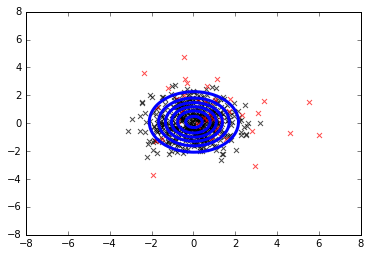

In [126]:
plt.scatter(true_obs[:,0], true_obs[:,1], marker='x', s=25, c='k', alpha=.7)
plt.scatter(noise_obs[:,0], noise_obs[:,1], marker='x', s=25, c='r', alpha=.7)

Z = bivariate_normal(X, Y, sigmax=final_params['sigma'][0,0], sigmay=final_params['sigma'][0,1], mux=final_params['mu'][0,0], muy=final_params['mu'][0,1], sigmaxy=0.)
plt.contour(X,Y,Z, colors='blue', linewidths=3)

plt.xlim([-plot_x_lim, plot_x_lim])
plt.ylim([-plot_y_lim, plot_y_lim])
plt.show()